In [170]:
!pip install yfinance --quiet
!pip install git+https://github.com/quantopian/pyfolio --quiet

In [10]:
import yfinance as yf # 주가데이터 가져오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from IPython.display import Image

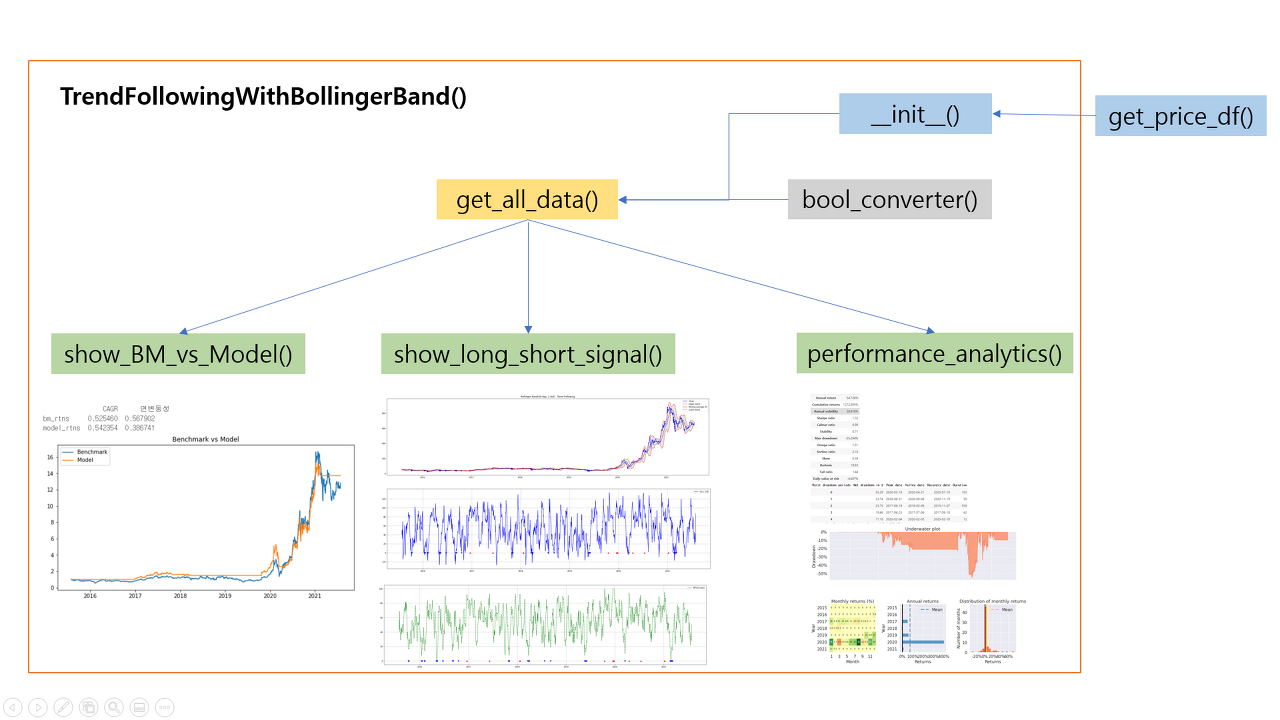

In [3]:
Image('TrendFollowingWithBollingerBand.png')

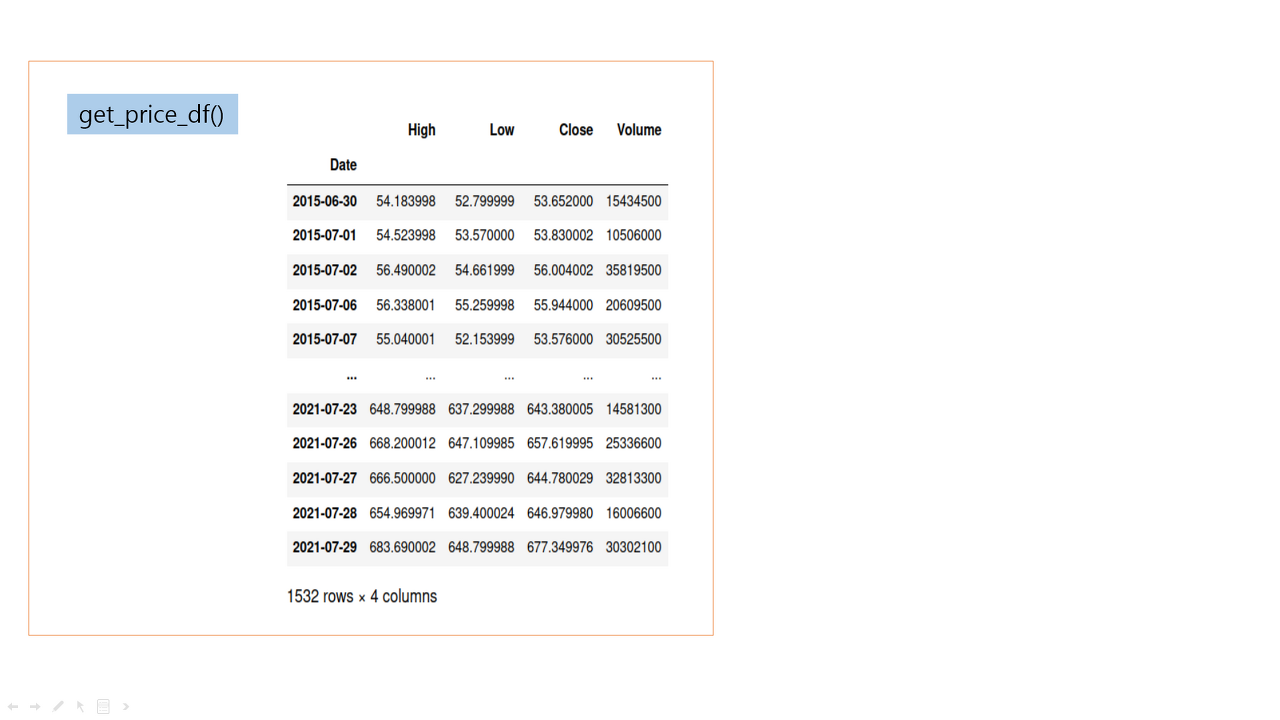

In [4]:
Image('get_price_df.png')

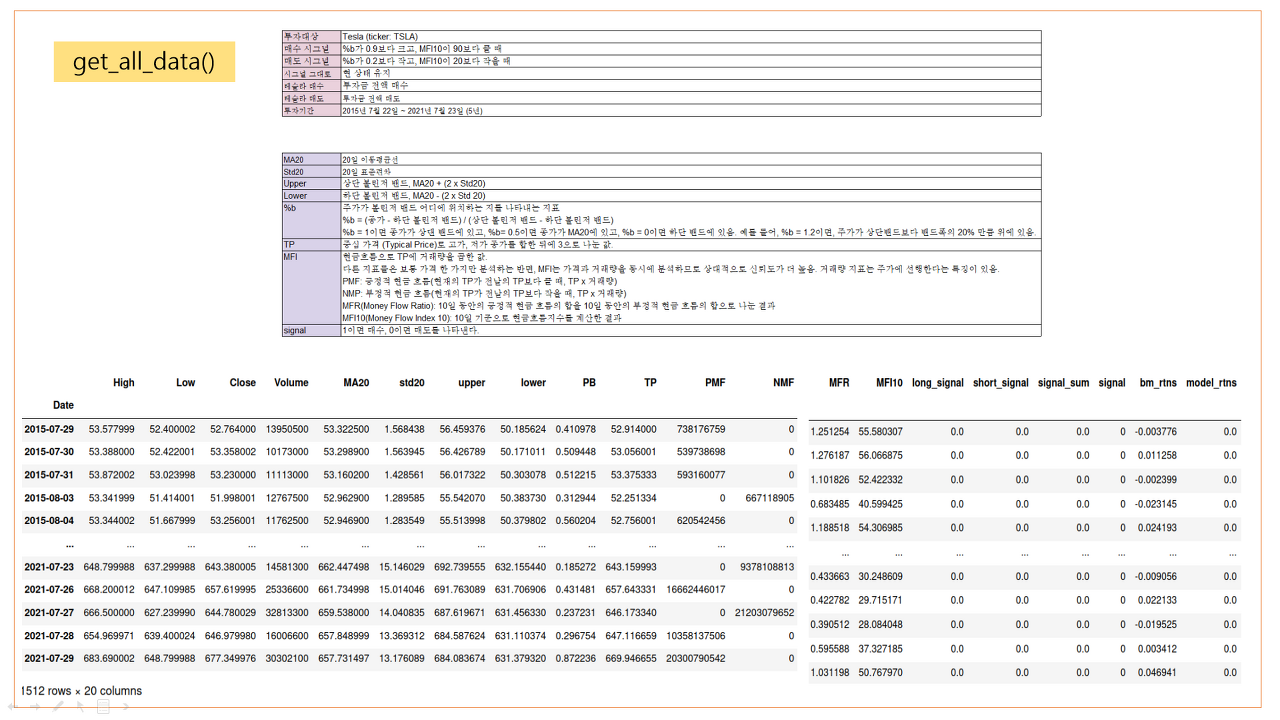

In [5]:
Image('get_all_data.png')

In [6]:
def get_price_df(ticker, start_date, end_date = datetime.datetime.now().strftime('%Y-%m-%d')):
    """Returns price dataframe from given URL
    Parameters
    ----------
    ticker : string
    start_date : string
    end_date : string
        
    Returns
    -------
    df : dataframe
        Imported High, Low, Close, Volume dataframe
    """
    df = yf.download(ticker, start_date,end_date)
    df.drop(columns = ['Open','Adj Close'],inplace = True) # 필요없는 column 빼기
    return df

In [7]:
get_price_df('TSLA', '2015-07-01')

[*********************100%***********************]  1 of 1 completed


,High,Low,Close,Volume
Date,,,,
2015-06-30,54.183998,52.799999,53.652000,15434500
2015-07-01,54.523998,53.570000,53.830002,10506000
2015-07-02,56.490002,54.661999,56.004002,35819500
2015-07-06,56.338001,55.259998,55.944000,20609500
2015-07-07,55.040001,52.153999,53.576000,30525500
...,...,...,...,...
2021-07-23,648.799988,637.299988,643.380005,14581300
2021-07-26,668.200012,647.109985,657.619995,25336600
2021-07-27,666.500000,627.239990,644.780029,32813300


In [8]:
class TrendFollowingWithBollingerBand:
    def __init__(self, High_Low_Close_Volume_df):
        self.all_data = self.get_all_data(High_Low_Close_Volume_df)
        self.show_BM_vs_Model(self.all_data[['bm_rtns', 'model_rtns']])
        self.show_long_short_signal(self.all_data[['Close','MA20','upper', 'lower','PB','MFI10']])
        self.performance_analytics(self.all_data['model_rtns']) 
    
    def get_all_data(self, High_Low_Close_Volume_df):
        """Returns the historical daily returns
        
        Paramters
        ---------
        prices : dataframe
            'High, Low, Close, Volume' data
            
        Returns
        -------
        returns : dataframe
            basic data and indicator data
        """
        df = High_Low_Close_Volume_df
        df['MA20'] = df['Close'].rolling(window=20).mean()# ① 20개 종가를 이용해서 평균을 구함
        df['std20'] = df['Close'].rolling(window=20).std()# ② 20개 종가를 이용해서 표준편차를 구함
        df['upper'] = df['MA20'] + (df['std20'] * 2 ) # ③ 상단 볼린저 밴드 = (중간 볼린저 밴드) + (2 * 표준편차)
        df['lower'] = df['MA20'] - (df['std20'] * 2 ) # ④ 하단 볼린저 밴드 = (중간 볼린저 밴드) - (2 * 표준편차)
        df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower']) # %b, 229개
        df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
        df['PMF'] = 0 # 긍정적 현금흐름
        df['NMF'] = 0 # 부정적 현금흐름
        for i in range(len(df.Close)-1):
            if df.TP.values[i] < df.TP.values[i+1]:
                df.PMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
                df.NMF.values[i+1] = 0
            else:
                df.NMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
                df.PMF.values[i+1] = 0
            df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
        df['MFI10'] = (100-100/(1+df['MFR']))


        long_signal = ((df[['PB']] >0.9).applymap(self.bool_converter))['PB'] + ((df[['MFI10']] >90).applymap(self.bool_converter))['MFI10']
        short_signal = (-(df[['PB']]<0.2).applymap(self.bool_converter))['PB'] + (-(df[['MFI10']] <20).applymap(self.bool_converter))['MFI10']
        long_signal = (long_signal.replace(1,0) )/2 # long_signal은 2일 때 매수시그널(1과 0은 무시)
        short_signal = (short_signal.replace(-1,0))/2 # short_signal은 -2일 때만 매도 시그널 (-1과 0은 무시)

        df['long_signal'] = long_signal
        df['short_signal'] = short_signal
        df['signal_sum'] = long_signal + short_signal # 1이면 매수, 0 이면 그대로, -1이면 매도 시그널
        df['signal']=0 # 현재 투자하고 있으면 1, 투자안하고 있으면 0
        for i, sig in enumerate(df.signal_sum):
            if (i==0): # 첫번째 행
                df.signal[i] = 0
            elif sig == 0:# 변화없음
                df.signal[i] = df.signal[i-1]
            elif sig == 1: # 투자하는 상태
                df.signal[i] = 1
            elif sig == -1: # 매도 시그널로 투자안하는 상태
                df.signal[i] = 0

        df['bm_rtns'] = df[['Close']].pct_change() # Benchmark Daily Returns
        df['model_rtns']=df.signal * df.bm_rtns # Model Daily Returns
        df.model_rtns.replace(-0.0,0,inplace=True) # Model의 -0인 부분 0으로 바꾸기
        df.bm_rtns.iloc[0]=0
        df.model_rtns.iloc[0]=0
        return df[20:]
    
    def show_BM_vs_Model(self, bm_model_rtns_df):
        """Compare Benchmark and Model
        Parameters
        ----------
        returns : dataframe
            'bm_rtns, model_rtns' data
            
        Returns
        -------
        None
        """
        result = bm_model_rtns_df
        wealth = (1 + result).cumprod()
        cagr = (wealth.iloc[-1] / wealth.iloc[0])**(250/(len(wealth)-1)) - 1
        risk = result.iloc[1:].std() * 250**0.5
        print(pd.DataFrame({'CAGR':cagr, '연변동성':risk}))

        plt.figure(figsize=(10,5))
        plt.title('Benchmark vs Model')
        plt.plot(wealth.index, wealth['bm_rtns'],  label='Benchmark')
        plt.plot(wealth.index, wealth['model_rtns'], label = 'Model')
        plt.legend(loc='best')
        plt.show()
        
    def show_long_short_signal(self, Close_MA20_upper_lower_PB_MFI10_df):
        """Show Long Short Signal
        Parameters
        ----------
        returns : dataframe
            'Close, MA20, upper, lower, %b, MFI10' data
            
        Returns
        -------
        None
        """
        df = Close_MA20_upper_lower_PB_MFI10_df
        plt.figure(figsize=(30,25))
        plt.subplot(3,1,1)
        plt.title('Bollinger Band(20 day, 2 std) - Trend Following')
        plt.plot(df.index, df['Close'], color = '#0000ff', label='Close')
        plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
        plt.plot(df.index, df['MA20'], 'k--', label = 'Moving average 20')
        plt.plot(df.index, df['lower'], 'r--', label = 'Lower band')
        plt.fill_between(df.index, df['upper'], df['lower'], color = '0.9')
        for i in range(len(df.Close)):
            if df.PB.values[i] > 0.9 and df.MFI10.values[i] > 90:
                plt.plot(df.index.values[i], df.Close.values[i], 'r^')
            elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
                plt.plot(df.index.values[i], df.Close.values[i], 'bv')
        plt.legend(loc='best')

        plt.subplot(3,1,2)
        plt.plot(df.index,df['PB']*100, 'b', label='%b x 100')
        plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
        for i in range(len(df.Close)):
            if df.PB.values[i] > 0.9 and df.MFI10.values[i] > 90:
                plt.plot(df.index.values[i], 0, 'r^')
            elif df.PB.values[i] < 0.2 and df.MFI10.values[i]<20:
                plt.plot(df.index.values[i], 0, 'bv')
        plt.grid(True)
        plt.legend(loc='best')

        plt.subplot(3,1,3)
        plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10 day)')
        plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
        for i in range(len(df.Close)):
            if df.PB.values[i] > 0.9 and df.MFI10.values[i] > 90:
                plt.plot(df.index.values[i], 0, 'r^')
            elif df.PB.values[i] < 0.2 and df.MFI10.values[i]<20:
                plt.plot(df.index.values[i], 0, 'bv')
        plt.grid(True)
        plt.legend(loc='best')
        plt.show();
        
    def performance_analytics(self, returns):
        """Returns Perforamnce Analytics using pyfolio package
        Parameters
        ----------
        returns : series
            backtestd portfolio returns
        Returns
        -------
        None
        """
        pf.create_returns_tear_sheet(returns)
    
    def bool_converter(self, bool_var):
        """Returns Integer Value from Boolean Value
        Parameters
        ----------
        bool_var : boolean
            Boolean variables representing trade signals
        Returns
        -------
        result : int
            Integer variables representing trade signals
        """
        if bool_var == True:
            result = 1
        elif bool_var == False:
            result = 0
        return result

[*********************100%***********************]  1 of 1 completed
                CAGR      연변동성
bm_rtns     0.525460  0.567902
model_rtns  0.542354  0.386741


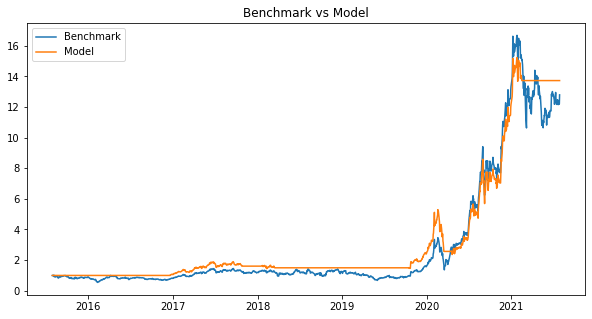

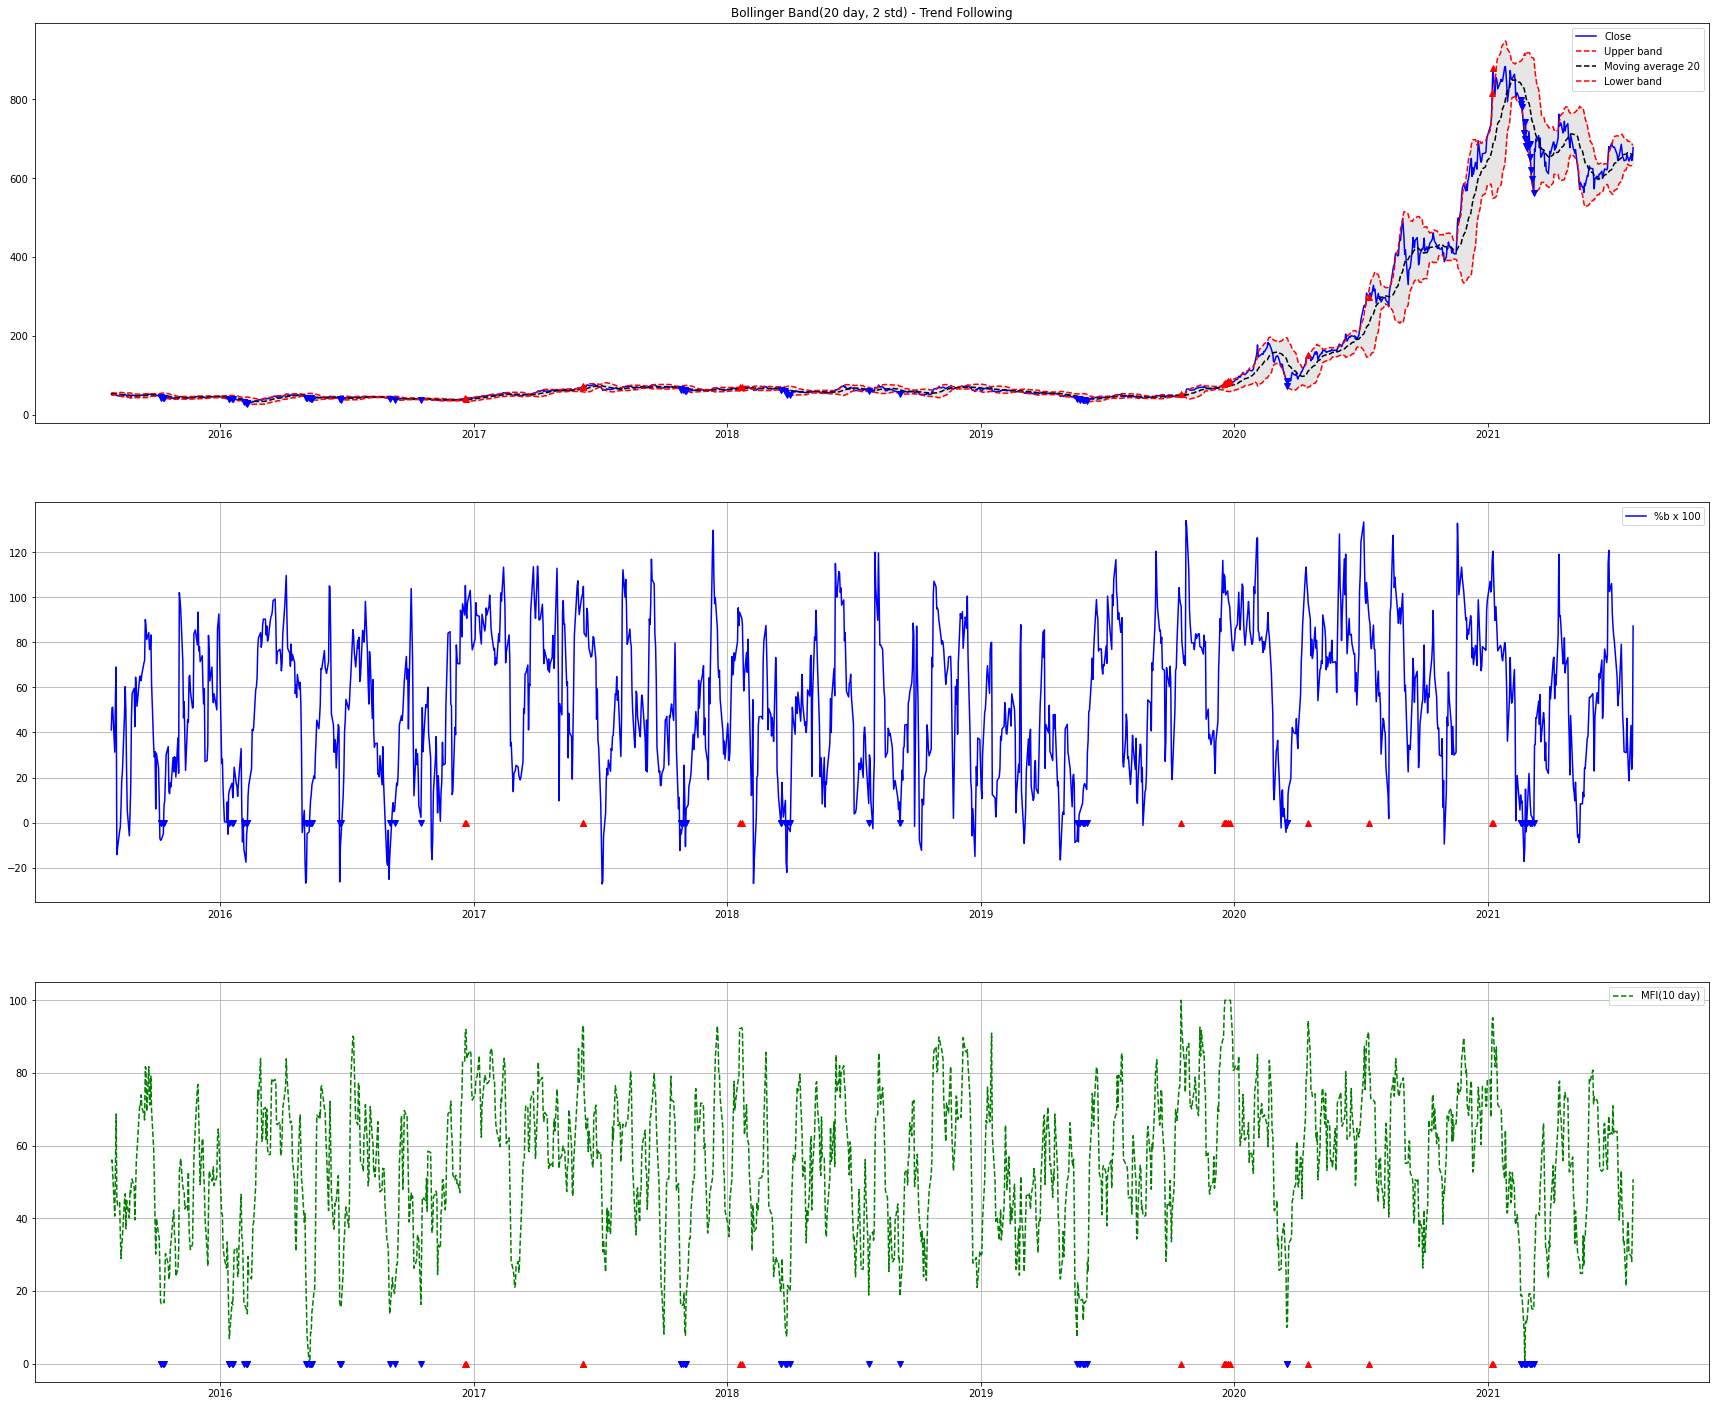

Start date,2015-07-29
End date,2021-07-29
Total months,72
,Backtest
Annual return,54.726%
Cumulative returns,1272.095%
Annual volatility,38.816%
Sharpe ratio,1.32
Calmar ratio,0.99
Stability,0.71
Max drawdown,-55.294%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55.29,2020-02-19,2020-04-21,2020-07-10,103
1,33.74,2020-08-31,2020-09-08,2020-11-19,59
2,23.75,2017-09-18,2018-02-09,2019-11-07,559
3,19.46,2017-06-23,2017-07-06,2017-09-18,62
4,17.18,2020-02-04,2020-02-05,2020-02-19,12


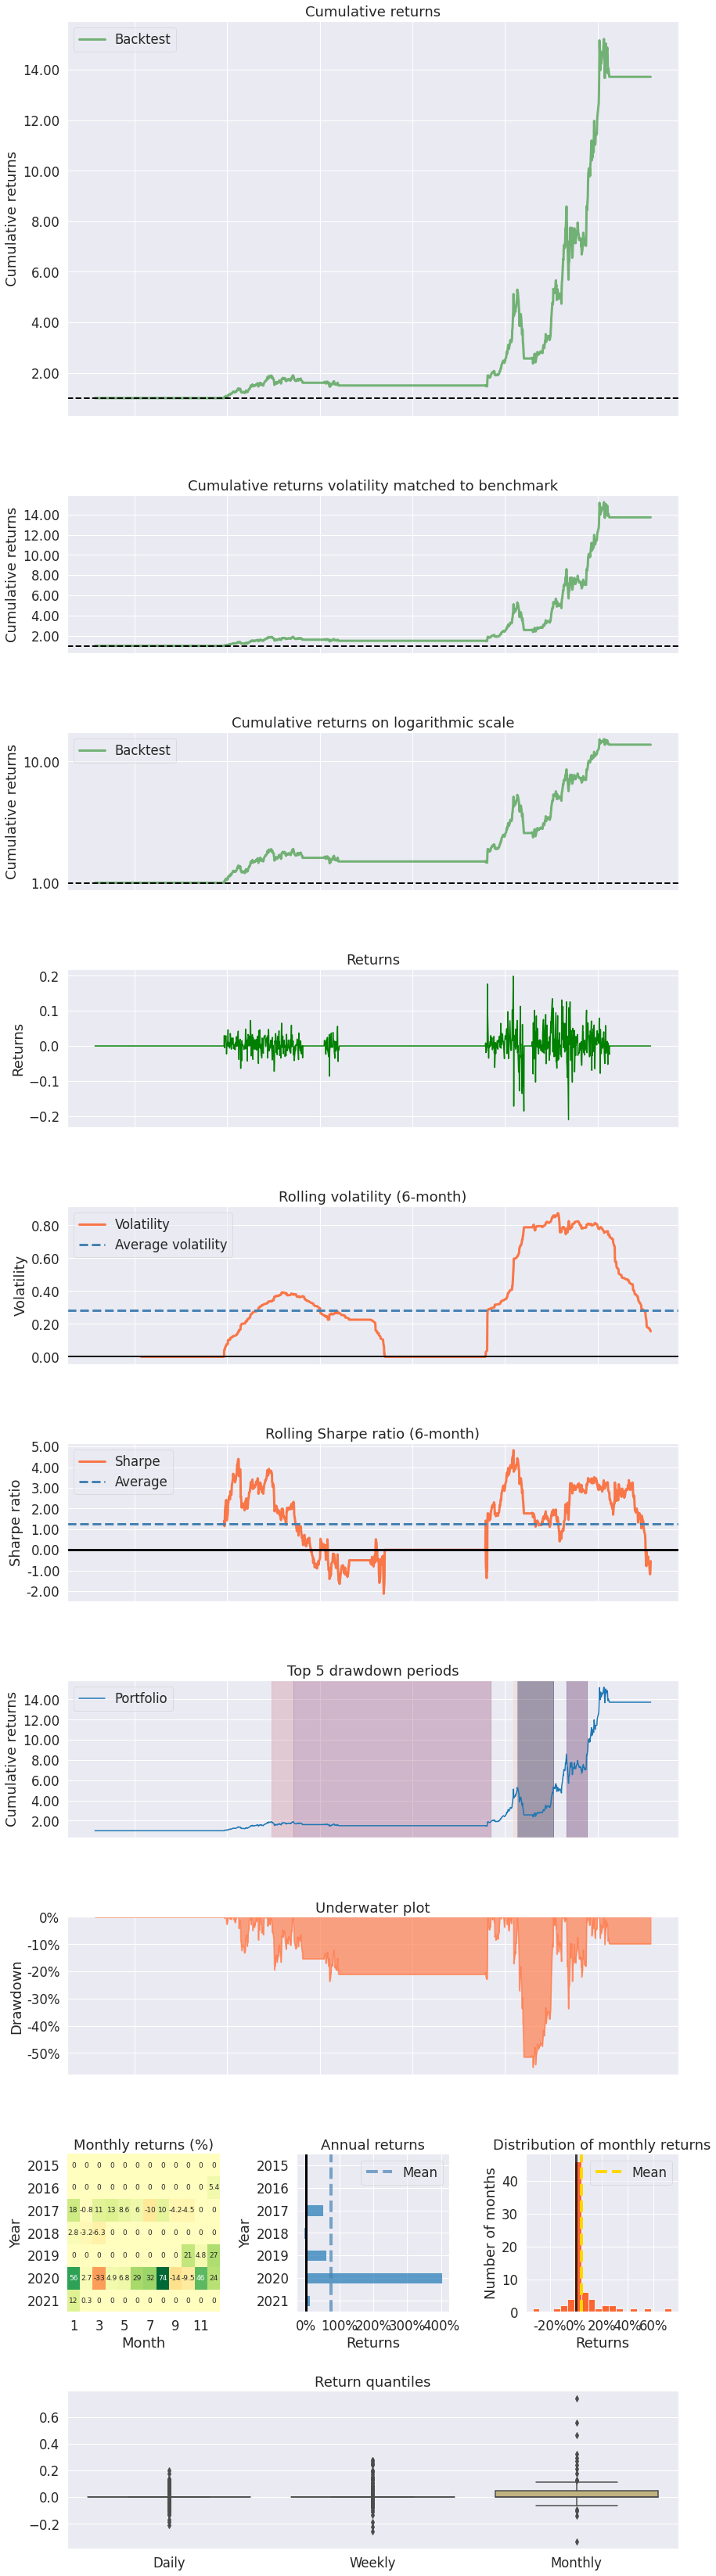

In [9]:
TrendFollowingWithBollingerBand(get_price_df('TSLA', '2015-07-01'))